https://aclanthology.org/W05-0909.pdf <br>
METEOR (Metric for Evaluation of Translation with Explicit ORdering) — это автоматическая метрика для оценки качества машинного перевода, впервые предложенная Сатябаной Банерджи и Аланом Лави в 2005 году. В отличие от классической метрики BLEU, METEOR была создана для более тонкой оценки перевода, учитывая не только точные совпадения слов, но и морфологические варианты, синонимы, а также порядок слов в предложении.

Работа метрики начинается с сопоставления слов между машинным переводом (гипотезой) и эталонным переводом (референсом). Сопоставление происходит на нескольких уровнях: сначала ищутся точные совпадения, затем совпадения по стеммингу, а после этого — по синонимии, например, с использованием лексических ресурсов вроде WordNet. После этого вычисляются две основные характеристики: точность (precision) — отношение числа совпавших слов к общему числу слов в гипотезе, и полнота (recall) — отношение числа совпавших слов к числу слов в референсе. Эти показатели объединяются в гармоническое среднее с весовым коэффициентом.

Однако METEOR идет дальше: чтобы учесть важность порядка слов, вводится штраф за фрагментацию. Если совпавшие слова расположены в разных частях предложения, образуя несколько непересекающихся последовательностей (так называемых "чанков"), итоговый балл уменьшается. Таким образом, метрика поощряет не только правильный выбор слов, но и их правильное расположение относительно друг друга.

Финальный балл METEOR вычисляется как произведение гармонического среднего точности и полноты на штраф за фрагментацию. Благодаря такому подходу, METEOR часто показывает более высокую корреляцию с человеческими оценками качества перевода, чем другие автоматические метрики.

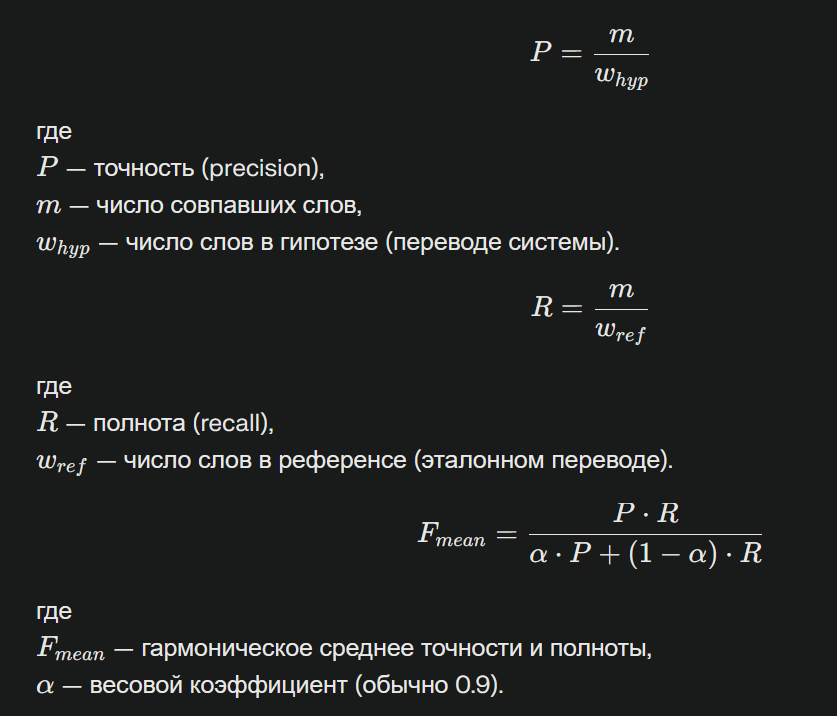
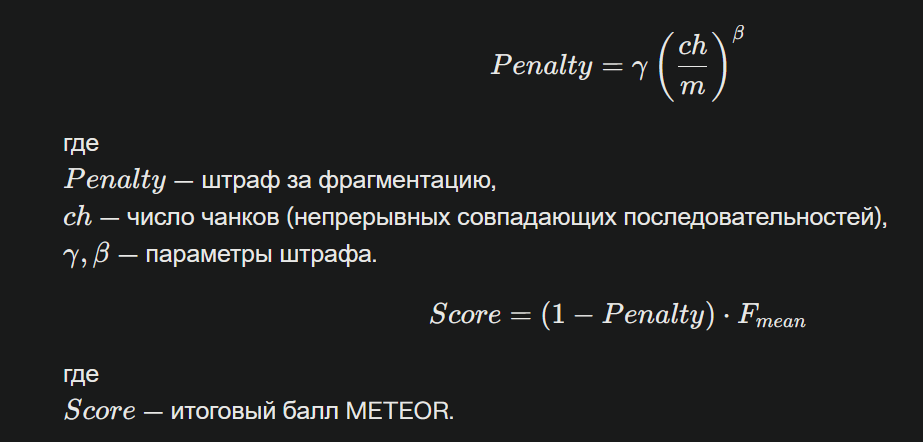

In [ ]:
!pip install nltk
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

In [ ]:
from nltk.translate.meteor_score import meteor_score

reference = "The quick brown fox jumps over the lazy dog".split()
candidate = "A fast brown fox leapt over a lazy dog".split()

score = meteor_score([reference], candidate)
print(f"METEOR Score: {score:.4f}")


METEOR Score: 0.7687


In [5]:
!pip install pymorphy2 ruwordnet
!ruwordnet download

downloading a ruwordnet model from https://github.com/avidale/python-ruwordnet/releases/download/0.0.4/ruwordnet-2021.db


In [ ]:
from ruwordnet import RuWordNet

wn = RuWordNet()

def get_synonyms(word):
    synonyms = set()
    for sense in wn.get_senses(word):
        for synonym in sense.synset.senses:
            synonyms.add(synonym.name.lower())
    return synonyms

print(get_synonyms('скакнуть'))  

{'попрыгать', 'прыгать', 'скакать', 'делать прыжок', 'сделать прыжок', 'скакнуть', 'прыгануть', 'сигать', 'запрыгать', 'сигануть', 'прыгнуть'}


In [115]:
import pymorphy2
from ruwordnet import RuWordNet

morph = pymorphy2.MorphAnalyzer()
wn = RuWordNet()

def tokenize(text):
    tokens = text.lower().strip().split()
    print(f"Токенизация: '{text}' -> {tokens}")
    return tokens

def lemmatize(tokens):
    lemmas = [morph.parse(token)[0].normal_form for token in tokens]
    print(f"Лемматизация: {tokens} -> {lemmas}")
    return lemmas

def get_synonyms(word):
    lemma = morph.parse(word)[0].normal_form
    synonyms = set()
    for sense in wn.get_senses(lemma):
        for synonym in sense.synset.senses:
            synonyms.add(synonym.name.lower())
    print(f"Синонимы для '{word}' (лемма '{lemma}'): {synonyms}")
    return synonyms
    

def align_matches(ref_tokens, cand_tokens, ref_lemmas, cand_lemmas):
    matches = []
    used_ref = set()
    print("\n1: Точные совпадения")
    for i, ctok in enumerate(cand_tokens):
        for j, rtok in enumerate(ref_tokens):
            if i not in [m[0] for m in matches] and j not in used_ref and ctok == rtok:
                matches.append((i, j))
                used_ref.add(j)
                print(f"Точное совпадение: candidate[{i}]='{ctok}' == reference[{j}]='{rtok}'")
                break

    print("\n2: Совпадения по леммам")
    for i, clemma in enumerate(cand_lemmas):
        for j, rlemma in enumerate(ref_lemmas):
            if i not in [m[0] for m in matches] and j not in used_ref and clemma == rlemma:
                matches.append((i, j))
                used_ref.add(j)
                print(f"Совпадение по лемме: candidate[{i}]='{cand_tokens[i]}'({clemma}) == reference[{j}]='{ref_tokens[j]}'({rlemma})")
                break

    print("\n3: Совпадения по синонимам")
    for i, clemma in enumerate(cand_lemmas):
        if i in [m[0] for m in matches]:
            continue
        cand_synonyms = get_synonyms(clemma)
        for j, rlemma in enumerate(ref_lemmas):
            if j in used_ref:
                continue
            if rlemma in cand_synonyms:
                matches.append((i, j))
                used_ref.add(j)
                print(f"Совпадение по синониму: candidate[{i}]='{cand_tokens[i]}'({clemma}) ~ reference[{j}]='{ref_tokens[j]}'({rlemma})\n")
                break

    matches.sort()
    print(f"\nВсе совпадения (индексы): {matches}")
    return matches

def count_chunks(matches):
    if not matches:
        return 0
    chunks = 1
    for k in range(1, len(matches)):
        if matches[k][0] != matches[k-1][0]+1 or matches[k][1] != matches[k-1][1]+1:
            chunks += 1
    print(f"Число фрагментов (chunks): {chunks}")
    return chunks

def meteor_score(reference, candidate, alpha=0.9, beta=3.0, gamma=0.5):
    ref_tokens = tokenize(reference)
    cand_tokens = tokenize(candidate)
    ref_lemmas = lemmatize(ref_tokens)
    cand_lemmas = lemmatize(cand_tokens)
    matches = align_matches(ref_tokens, cand_tokens, ref_lemmas, cand_lemmas)
    m = len(matches)
    print(f"Число совпадений (matches): {m}")
    if m == 0:
        print("Нет совпадений — METEOR = 0.0\n")
        return 0.0
    precision = m / len(cand_tokens)
    recall = m / len(ref_tokens)
    print(f"Precision: {precision:.4f} (совпадения/кандидат)\nRecall: {recall:.4f} (совпадения/референс)")
    fmean = (precision * recall) / (alpha * precision + (1 - alpha) * recall)
    print(f"Fmean: {fmean:.4f}")
    chunks = count_chunks(matches)
    penalty = gamma * (chunks / m) ** beta
    print(f"Penalty: {penalty:.4f}")
    score = (1 - penalty) * fmean
    print(f"METEOR Score: {score:.4f}\n")
    return score

reference = "Быстрая коричневая лиса прыгнула на грустную собаку"
candidate = "Стремительная рыжая лисичка скакнула на унылую собачку"
score = meteor_score(reference, candidate)
print(f"Итоговый METEOR Score: {score:.4f}")


Токенизация: 'Быстрая коричневая лиса прыгнула на грустную собаку' -> ['быстрая', 'коричневая', 'лиса', 'прыгнула', 'на', 'грустную', 'собаку']
Токенизация: 'Стремительная рыжая лисичка скакнула на унылую собачку' -> ['стремительная', 'рыжая', 'лисичка', 'скакнула', 'на', 'унылую', 'собачку']
Лемматизация: ['быстрая', 'коричневая', 'лиса', 'прыгнула', 'на', 'грустную', 'собаку'] -> ['быстрый', 'коричневый', 'лиса', 'прыгнуть', 'на', 'грустный', 'собака']
Лемматизация: ['стремительная', 'рыжая', 'лисичка', 'скакнула', 'на', 'унылую', 'собачку'] -> ['стремительный', 'рыжий', 'лисичка', 'скакнуть', 'на', 'унылый', 'собачка']

1: Точные совпадения
Точное совпадение: candidate[4]='на' == reference[4]='на'

2: Совпадения по леммам

3: Совпадения по синонимам
Синонимы для 'стремительный' (лемма 'стремительный'): {'стремительный'}
Синонимы для 'рыжий' (лемма 'рыжий'): {'рыжий', 'рыжеватый'}
Синонимы для 'лисичка' (лемма 'лисичка'): {'лисичка', 'лисица', 'лиса'}
Совпадение по синониму: candidat

In [ ]:
!pip install navec scipy

In [ ]:
from navec import Navec
import numpy as np

path = 'models/navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

def get_nearest_words_fast(navec, word, topn=20):
    if word not in navec:
        print(f"Слово '{word}' не найдено в словаре navec.")
        return []
    word_vec = navec[word]
    all_words = np.array(navec.vocab.words)
    all_vecs = np.stack([navec[w] for w in all_words])
    word_vec_norm = word_vec / np.linalg.norm(word_vec)
    all_vecs_norm = all_vecs / np.linalg.norm(all_vecs, axis=1, keepdims=True)
    sims = np.dot(all_vecs_norm, word_vec_norm)
    mask = (all_words != word)
    all_words = all_words[mask]
    sims = sims[mask]
    idx = np.argsort(-sims)[:topn]
    return list(zip(all_words[idx], sims[idx]))

word = 'над'
nearest = get_nearest_words_fast(navec, word)
print(f"Ближайшие слова к '{word}':")
for w, score in nearest:
    print(f"{w}: {score:.4f}")


Ближайшие слова к 'над':
городом: 0.5339
высоко: 0.4823
надъ: 0.4812
нависла: 0.4711
перед: 0.4663
землей: 0.4607
ними: 0.4580
озером: 0.4575
небо: 0.4557
небе: 0.4541
головами: 0.4486
воздухе: 0.4470
рядом: 0.4446
равниной: 0.4441
морем: 0.4414
ним: 0.4402
полем: 0.4399
нависала: 0.4331
поляной: 0.4322
нашими: 0.4311


C:\Users\maxik\AppData\Local\Temp\ipykernel_10108\2133214220.py:17: RuntimeWarning: invalid value encountered in divide
  all_vecs_norm = all_vecs / np.linalg.norm(all_vecs, axis=1, keepdims=True)


In [ ]:
!pip install razdel 

In [3]:
from razdel import tokenize
tokens = list(tokenize('мама сшила мне штаны'))

display(tokens)

[Substring(0, 4, 'мама'),
 Substring(5, 10, 'сшила'),
 Substring(11, 14, 'мне'),
 Substring(15, 20, 'штаны')]